## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

In [1]:
from disc_f import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 20
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 2240
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z_all     = 20,33,30,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_amrkers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)
V, T_init, u_n         = initial_u_n(domain, Ti)
fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup(domain, V,mesh_name1,num_steps, \
                         angular_r, mesh_name2, c_contact,z_all,Tm, S_rub_circle)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init,domain, rho, c, b_con,\
                          radiation, h, k, xdmf,dt,ds,u_n, Tm,g,bc);
n,converged = solver_setup_solve(problem,u)
## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
#num_steps=20
T_array     = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r,t_brake, \
                     domain,S_rub_circle,fdim, rho, c, v, radiation, k, h, \
                     f,Tm,u_n,g, ds, xdmf, b_con,bc,plotter,warped)
csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
# got the Temperature data
save_t_T(csv_name, T_array)

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  48.05 s
2: Total numb steps is  62
The file 'm-3-20.msh' exists, start creat now:
Info    : Reading 'm-3-20.msh'...
Info    : 168 entities
Info    : 2532 nodes
Info    : 8476 elements
Info    : Done reading 'm-3-20.msh'

1: Progress: 98.1%. Use time: 0 hours 1 min. Start: 2024-10-21 20:59:05.        
t and T have been successfully saved as Result_T-s-62-d-2240-m-3-20-c-1-e-8476.csv


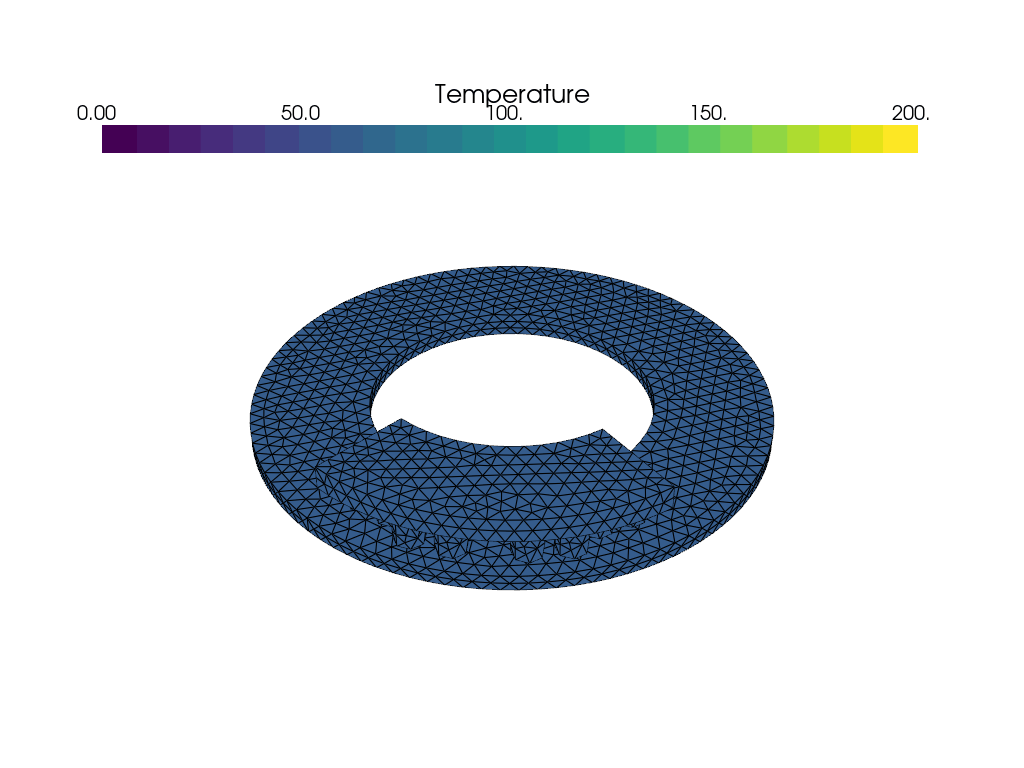

In [2]:
from IPython.display import display, Image
display(Image(gif_name))

# 2 Deformation

In [35]:
from dolfinx import log
log.set_log_level(log.LogLevel.ERROR)  # Disable INFO and lower logs

mesh_points= meshio.read(mesh_name1).points 
function_values = u_n.x.array  
print('Length of mesh points is ', len(mesh_points))  #whole brake pad and disc
print("Length of result T is ",    len(function_values)) # for each timpe step, how many T saved

# want to get the brake pad T
pad_index = find_pad_cell_index(mesh_name1) # through physcial volume name of brake pad
physical_tags = mesh_brake.cell_data["gmsh:physical"][pad_index]  #cell_data is dictionary type
pad_cell_mask = (physical_tags == pad_v_tag)
pad_cells = mesh_brake.cells[pad_index].data[pad_cell_mask]
    # Get the unique node indices corresponding to the brake pad
pad_node_indices = np.unique(pad_cells.flatten())
pad_node_coordinates = mesh_brake.points[pad_node_indices]
print('Brake pad nodes number is ',len(pad_node_coordinates))

##########################################################
domain_pad, cell_mark_pad, facet_mark_pad, mesh_name_pad,\
mesh_name1_pad, mesh_name2_pad = mesh_brake_pad1 (mesh_min,mesh_max)
#########################################################

from scipy.spatial import cKDTree
    # Step 1: Read the mesh using meshio
#mesh_brake_pad = meshio.read(mesh_name1_pad)
#mesh_points_pad = mesh_brake_pad.points  # This is a NumPy array of shape (n_points, dim)
mesh_brake = meshio.read(mesh_name1)
mesh_points = mesh_brake.points


tree = cKDTree(pad_node_coordinates) #node_coordinates are from calculation
#distances, indices = tree.query(mesh_points_pad)
#T_new_p = np.zeros(len(mesh_points_pad))  # Array to hold temperatures for mesh_points_pad
distances, indices = tree.query(mesh_points)
T_new_p = np.zeros(len(mesh_points))

for i, index in enumerate(indices):
      T_new_p[i] = u_n.x.array[index]  # Assign temperature from u_n based on nearest index

print('length from new mesh is:\n',len(mesh_points_pad))
print('length from calculation is:\n',len(pad_node_coordinates))
    #print("Temperatures assigned to mesh_points_pad:\n", T_new_p)
print("Temperatures assigned to new mesh length is:\n",len(T_new_p))


def plot_T_pad(domain_pad, T_new_p):
    gdim,fdim = 3,2
    pyvista.start_xvfb()
    topology, cell_types, geometry = plot.vtk_mesh(domain_pad, gdim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["Temperature/ °C"] = T_new_p
    grid.set_active_scalars("Temperature/ °C")
    plotter = pyvista.Plotter()

    sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.85, width=0.8, height=0.1)
    plotter.add_mesh(grid, show_edges=True,scalar_bar_args=sargs,clim=[0, 200])

    plotter.camera.azimuth = -5
    plotter.camera.elevation = 180  
    plotter.window_size = (800, 400)
    plotter.zoom_camera(1.5)
    return plotter
    
#T_new_p, domain_pad = T_pad_transfer( mesh_name1, u_n, mesh_min, mesh_max, mesh_brake, pad_v_tag);
plotter             = plot_T_pad( domain_pad, T_new_p)
plotter.show()
figure = plotter.screenshot("T_pad.png")

VT      = fem.functionspace(domain_pad, ("CG", 1))    #define the finite element function space
Delta_T = fem.Function(VT, name ="Temperature_variation")  # T_ is the test function, like v
for i in range(len(T_new_p)):
    Delta_T.vector.array[i] = T_new_p[i]

#######try to make domain only for brake pad.
E    = fem.Constant(domain_pad, 50e3)             # Elastic module
nu   = fem.Constant(domain_pad, 0.2)             # Poission ratio
gdim = domain_pad.geometry.dim

mu    = E / 2 / (1 + nu)                      # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)   # Lame parameters
alpha = fem.Constant(domain_pad, 1e-5)         # Thermal expansion coefficient
f1    = fem.Constant(domain_pad, (0.0, 0.0, 0.0))       # O for external force

def eps(v):                                # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))

def sigma(v, Delta_T):                     # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T 
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)     # here braces is important, can not be in above line

Vu = fem.functionspace(domain_pad, ("CG", 1, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM   = ufl.lhs(Wint)                                      # Wint is long and lhs can help to distinguish unkown and know.
LM   = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx         # knows parameters are in lhs

def up_side(x):
    return np.logical_or(np.isclose(x[2], 53), np.isclose(x[2], 83))
    
up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side) # lateral sides of domain
bcu       = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

u_d     = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()

plot_s_pad = plot_S_pad(Vu,u_d )
plot_s_pad.show()
figure = plot_s_pad.screenshot("T_pad.png")


Length of mesh points is  2532
Length of result T is  2532

Brake pad nodes number is  840
The file 'm-3-20_pad.msh' exists, start creat now:
Info    : Reading 'm-3-20_pad.msh'...
Info    : 153 entities
Info    : 842 nodes
Info    : 2405 elements
Info    : Done reading 'm-3-20_pad.msh'

length from new mesh is:
 842
length from calculation is:
 840
Temperatures assigned to new mesh length is:
 2532


ValueError: data length of (2532) != required length (842)

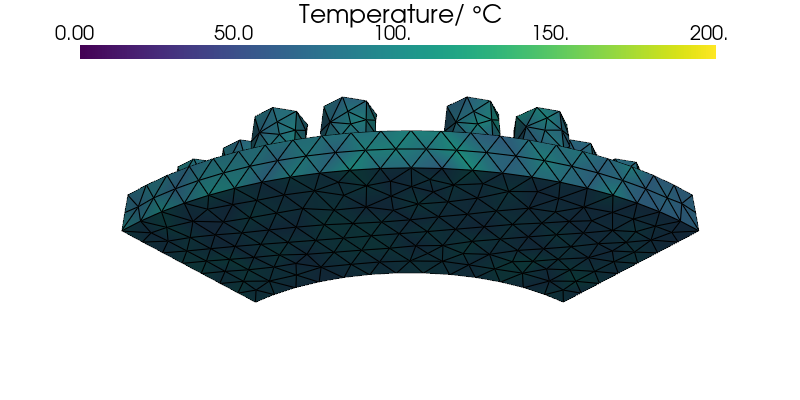

In [4]:
plotter             = plot_T_pad( domain_pad, T_new_p)

plotter.camera.elevation = 0
plotter.show()

In [36]:
for i, index in enumerate(indices):
    print(i, index)

0 250
1 250
2 3
3 28
4 0
5 1
6 2
7 3
8 4
9 5
10 6
11 7
12 8
13 9
14 10
15 11
16 12
17 13
18 14
19 15
20 16
21 17
22 18
23 19
24 20
25 21
26 22
27 23
28 24
29 25
30 26
31 27
32 28
33 29
34 30
35 31
36 32
37 33
38 34
39 35
40 36
41 37
42 38
43 39
44 40
45 41
46 42
47 43
48 250
49 257
50 257
51 279
52 278
53 314
54 314
55 313
56 307
57 306
58 328
59 327
60 6
61 6
62 6
63 6
64 6
65 6
66 6
67 6
68 6
69 6
70 6
71 6
72 6
73 6
74 6
75 6
76 6
77 6
78 6
79 6
80 6
81 7
82 7
83 7
84 7
85 7
86 7
87 7
88 7
89 7
90 7
91 7
92 7
93 7
94 7
95 7
96 7
97 7
98 7
99 7
100 7
101 7
102 250
103 257
104 257
105 279
106 278
107 314
108 314
109 313
110 307
111 306
112 328
113 327
114 327
115 327
116 6
117 6
118 6
119 6
120 6
121 6
122 6
123 6
124 6
125 6
126 6
127 6
128 6
129 6
130 6
131 6
132 6
133 6
134 6
135 7
136 7
137 7
138 7
139 7
140 7
141 7
142 7
143 7
144 7
145 7
146 7
147 7
148 7
149 7
150 7
151 7
152 7
153 7
154 251
155 250
156 66
157 67
158 68
159 69
160 33
161 33
162 296
163 42
164 359
165 359
166 76

In [37]:
print(T_new_p)
np.set_printoptions(threshold=np.inf)

[ 85.77513149  85.77513149  66.70987332  72.80810428  65.98619532
  67.33078499  69.18903093  66.70987332  68.38965846  65.11793096
  68.55580892  66.05415879  67.44693534  64.87122898  67.87612739
  73.00410466  66.50211888  64.13043441  64.62816026  70.24059766
  71.72744262  66.21629023  69.9566203   64.28267661  75.84414675
  71.35417906  73.42331308  79.03348795  81.65198222  65.9506857
  64.27185376  72.95370212  72.80810428  64.27711356  89.48148378
  75.44178203  70.82861267  66.42366322  77.54674929  75.68327638
  64.87692828  66.3355319   87.51541736  71.74582261  81.83600228
  64.8307696   73.41854012  93.19327611  85.77513149  95.09989248
  95.09989248  62.42787438  64.82745694  77.68744499  77.68744499
  96.15259566  92.21185595  95.53665903 104.47635175  79.65555692
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.555808

In [50]:
print(len(T_new_p))
print(u_n.x.array.size)
print(len(pad_node_indices))
#print(pad_node_indices)
T_pad = np.zeros(u_n.x.array.size)
for i in pad_node_indices:
    T_pad[i] = u_n.x.array[pad_node_indices[i]]
print(T_pad)

2532
2532
840


IndexError: index 2044 is out of bounds for axis 0 with size 840

In [30]:
print(len(T_new_p))
print(T_new_p)

2532
[ 85.77513149  85.77513149  66.70987332  72.80810428  65.98619532
  67.33078499  69.18903093  66.70987332  68.38965846  65.11793096
  68.55580892  66.05415879  67.44693534  64.87122898  67.87612739
  73.00410466  66.50211888  64.13043441  64.62816026  70.24059766
  71.72744262  66.21629023  69.9566203   64.28267661  75.84414675
  71.35417906  73.42331308  79.03348795  81.65198222  65.9506857
  64.27185376  72.95370212  72.80810428  64.27711356  89.48148378
  75.44178203  70.82861267  66.42366322  77.54674929  75.68327638
  64.87692828  66.3355319   87.51541736  71.74582261  81.83600228
  64.8307696   73.41854012  93.19327611  85.77513149  95.09989248
  95.09989248  62.42787438  64.82745694  77.68744499  77.68744499
  96.15259566  92.21185595  95.53665903 104.47635175  79.65555692
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.55580892  68.55580892  68.55580892  68.55580892  68.55580892
  68.5

In [31]:
c = u_n.x.array
print(len(c))
print(c)

2532
[ 65.98619532  67.33078499  69.18903093  66.70987332  68.38965846
  65.11793096  68.55580892  66.05415879  67.44693534  64.87122898
  67.87612739  73.00410466  66.50211888  64.13043441  64.62816026
  70.24059766  71.72744262  66.21629023  69.9566203   64.28267661
  75.84414675  71.35417906  73.42331308  79.03348795  81.65198222
  65.9506857   64.27185376  72.95370212  72.80810428  64.27711356
  89.48148378  75.44178203  70.82861267  66.42366322  77.54674929
  75.68327638  64.87692828  66.3355319   87.51541736  71.74582261
  81.83600228  64.8307696   73.41854012  93.19327611  91.07959409
  65.23670185  73.28514659  88.81297262  80.57178565  70.18232052
  81.36018516  73.03496304  67.65945615  75.77599792  85.05820417
  84.26531769  65.75711437  78.81197927  77.48592414  70.02570626
  67.8962507   87.10543196  74.04480837  72.15101079  87.75215082
  85.43719929  65.85077095  65.73503766  88.97905104  96.0629594
  74.08811163  81.47890438  70.69373178  95.64069099  87.4642169
  92.66

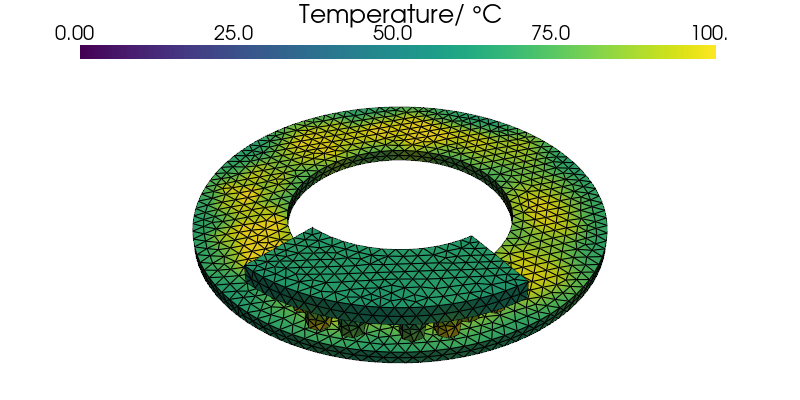

In [34]:

def plot_T_disc(domain, u_n):
    gdim,fdim = 3,2
    pyvista.start_xvfb()
    topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["Temperature/ °C"] = u_n.x.array
    grid.set_active_scalars("Temperature/ °C")
    plotter = pyvista.Plotter()

    sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.85, width=0.8, height=0.1)
    plotter.add_mesh(grid, show_edges=True,scalar_bar_args=sargs,clim=[0, 100])

    
    plotter.window_size = (800, 400)
    plotter.zoom_camera(1.5)
    return plotter
    
#T_new_p, domain_pad = T_pad_transfer( mesh_name1, u_n, mesh_min, mesh_max, mesh_brake, pad_v_tag);
plotter  = plot_T_disc( domain, u_n)
plotter.show()

In [ ]:

def plot_T_disc(domain_pad, T):
    gdim,fdim = 3,2
    pyvista.start_xvfb()
    topology, cell_types, geometry = plot.vtk_mesh(domain_pad, gdim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    
    grid.point_data["Temperature/ °C"] = T.x.array
    grid.set_active_scalars("Temperature/ °C")
    plotter = pyvista.Plotter()

    sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.85, width=0.8, height=0.1)
    plotter.add_mesh(grid, show_edges=True,scalar_bar_args=sargs,clim=[0, 100])

    
    plotter.window_size = (800, 400)
    plotter.zoom_camera(1.5)
    return plotter
    
#T_new_p, domain_pad = T_pad_transfer( mesh_name1, u_n, mesh_min, mesh_max, mesh_brake, pad_v_tag);
plotter  = plot_T_disc( domain_pad, u_n)
plotter.show()